In [8]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])  # Assuming many-to-one
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
                  weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
        return hidden

# Assuming the parameters for the LSTM model
input_size = 21
hidden_size = 128
num_layers = 3
output_size = 1

# Create an instance of LSTMModel
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
lstm_model

LSTMModel(
  (lstm): LSTM(21, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [9]:
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
dfs = []
labels = []
for company in ['AAPL', 'AMD', 'AMZN', 'ASML','CSCO']:
    df_numerical = pd.read_csv('../dataset_transcript/EPS/'+company+'_EPS.csv')
    df_textural = pd.read_csv('../dataset_transcript/Transcripts/'+company+'_sentiment.csv')
    df_result = pd.read_csv('../dataset_transcript/Stock Values and Sector Index/'+company+'.csv')
    df_combined = pd.merge(df_result, df_textural, how="left", on=["Date"])
    df_combined = pd.merge(df_combined, df_numerical, how="left", on=["Date"])
    df_combined.fillna(0, inplace = True) 
    df_combined=df_combined.drop(columns=['Fiscal Quarter End', 'Date'])
    dfs.append(df_combined)
    labels.append(df_result['Close'])
test_size = 1

train_features = torch.cat([torch.tensor(df.values).float() for df in dfs[:-test_size]])  # Assuming dfs[:-test_size] would work this way
train_labels = torch.cat([torch.tensor(label.values).float() for label in labels[:-test_size]])  # Similar handling for labels

test_features = torch.cat([torch.tensor(df.values).float() for df in dfs[-test_size:]])  # Assuming dfs[:-test_size] would work this way
test_labels = torch.cat([torch.tensor(label.values).float() for label in labels[-test_size:]])  # Similar handling for labels

train_features = train_features.view(4, -1, 21)
test_features = test_features.view(4, -1, 21)
train_labels = train_labels.view(4, -1) 
test_labels = test_labels.view(4, -1) 

# Create TensorDataset
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoader
# Here batch_size is 1 because each batch is already pre-prepared
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Shuffling batches, not within batches
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)  # Shuffling batches, not within batches


In [31]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Assuming you have a function to generate predictions
def generate_predictions(data, model):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    hidden = model.init_hidden(1)  # Initialize hidden state for the start of the sequence

    with torch.no_grad():  
        for i in range(data.size(0)):
            output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
            hidden = (hidden[0].detach(), hidden[1].detach())  # Detach hidden state
            predictions.append(output.squeeze().item())  # Collect the prediction
    return predictions

In [11]:
from tqdm import tqdm

def train_model(loader, model, optimizer, criterion, epochs):
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0

        for data, labels in loader:
            data = data.squeeze(0)  # Assuming data comes in as [1, sequence, features]
            labels = labels.squeeze(0)  # Assuming labels come in as [1, sequence]
            hidden = model.init_hidden(1) 
            for i in range(data.size(0)):  # Iterate over each time step
                optimizer.zero_grad()
                
                # Forward pass 
                output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
                
                # Detach hidden states; otherwise, the graph will try to backpropagate through all previous steps
                hidden = (hidden[0].detach(), hidden[1].detach())
                
                # Compute loss
                loss = criterion(output, labels[i:i+1])
                loss.backward()  # Compute gradients
                optimizer.step()  # Update model parameters
                
                total_loss += loss.item()

        if (epoch+1) %(epochs//10) == 0:
            print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(loader)}')

In [33]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
train_model(train_loader, lstm_model, optimizer, criterion, epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/jiaruiz/miniforge3/envs/6998/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 9/1000 [01:26<2:39:26,  9.65s/it]

torch.Size([1, 1196, 21])
<built-in method size of Tensor object at 0x31cf5d540>
49.58252716064453
36.238731384277344
105.26397705078125
80.7396011352539
121.44634246826172
103.74223327636719
114.67848205566406
107.31930541992188
112.56932067871094
109.134033203125
111.59941101074219
109.94361877441406
111.12225341796875
110.32742309570312
110.895263671875
110.5140151977539
110.78829956054688
110.60546875
110.73817443847656
110.65055084228516
110.7148666381836
110.67295837402344
110.70425415039062
110.68428802490234
110.69960021972656
110.69015502929688
110.69767761230469
110.69329833984375
110.69706726074219
110.69512176513672
110.697021484375
110.69620513916016
110.69721221923828
110.6969223022461
110.69749450683594
110.69750213623047
110.69786071777344
110.69793701171875
110.69815826416016
110.69830322265625
110.69847869873047
110.69864654541016
110.69878387451172
110.69890594482422
110.69903564453125
110.69918060302734
110.69931030273438
110.699462890625
110.69952392578125
110.6996

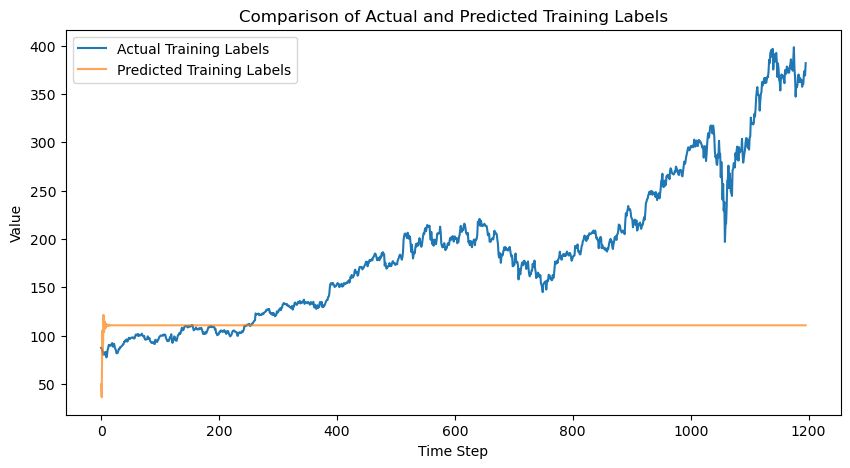

torch.Size([1, 1196, 21])
<built-in method size of Tensor object at 0x31c72bf70>
49.58252716064453
36.238731384277344
105.26397705078125
80.7396011352539
121.44634246826172
103.74223327636719
114.67848205566406
107.31930541992188
112.56932067871094
109.134033203125
111.59941101074219
109.94361877441406
111.12225341796875
110.32742309570312
110.895263671875
110.5140151977539
110.78829956054688
110.60546875
110.73817443847656
110.65055084228516
110.7148666381836
110.67295837402344
110.70425415039062
110.68428802490234
110.69960021972656
110.69015502929688
110.69767761230469
110.69329833984375
110.69706726074219
110.69512176513672
110.697021484375
110.69620513916016
110.69721221923828
110.6969223022461
110.69749450683594
110.69750213623047
110.69786071777344
110.69793701171875
110.69815826416016
110.69830322265625
110.69847869873047
110.69864654541016
110.69878387451172
110.69890594482422
110.69903564453125
110.69918060302734
110.69931030273438
110.699462890625
110.69952392578125
110.6996

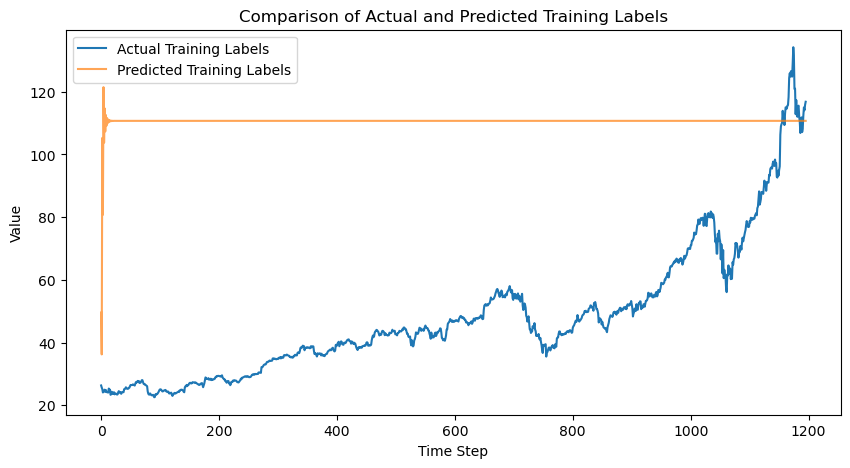

torch.Size([1, 1196, 21])
<built-in method size of Tensor object at 0x31df92c10>
49.58252716064453
36.238731384277344
105.26397705078125
80.7396011352539
121.44634246826172
103.74223327636719
114.67848205566406
107.31930541992188
112.56932067871094
109.134033203125
111.59941101074219
109.94361877441406
111.12225341796875
110.32742309570312
110.895263671875
110.5140151977539
110.78829956054688
110.60546875
110.73817443847656
110.65055084228516
110.7148666381836
110.67295837402344
110.70425415039062
110.68428802490234
110.69960021972656
110.69015502929688
110.69767761230469
110.69329833984375
110.69706726074219
110.69512176513672
110.697021484375
110.69620513916016
110.69721221923828
110.6969223022461
110.69749450683594
110.69750213623047
110.69786071777344
110.69793701171875
110.69815826416016
110.69830322265625
110.69847869873047
110.69864654541016
110.69878387451172
110.69890594482422
110.69903564453125
110.69918060302734
110.69931030273438
110.699462890625
110.69952392578125
110.6996

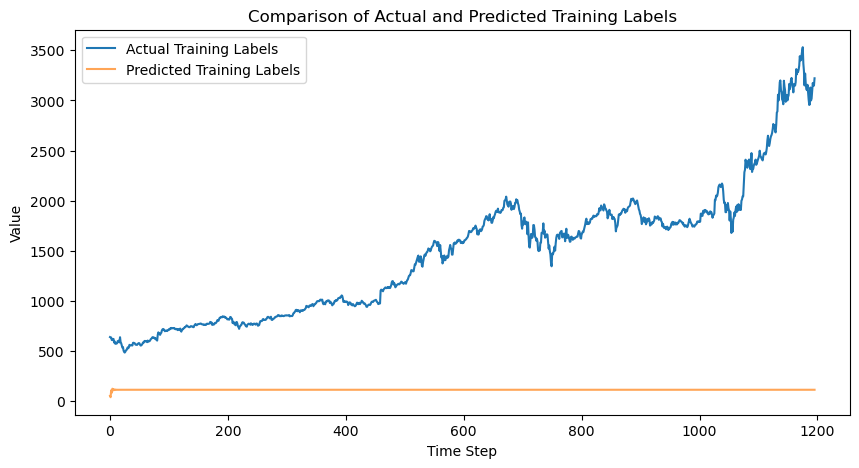

torch.Size([1, 1196, 21])
<built-in method size of Tensor object at 0x31df92da0>
49.58252716064453
36.238731384277344
105.26397705078125
80.7396011352539
121.44634246826172
103.74223327636719
114.67848205566406
107.31930541992188
112.56932067871094
109.134033203125
111.59941101074219
109.94361877441406
111.12225341796875
110.32742309570312
110.895263671875
110.5140151977539
110.78829956054688
110.60546875
110.73817443847656
110.65055084228516
110.7148666381836
110.67295837402344
110.70425415039062
110.68428802490234
110.69960021972656
110.69015502929688
110.69767761230469
110.69329833984375
110.69706726074219
110.69512176513672
110.697021484375
110.69620513916016
110.69721221923828
110.6969223022461
110.69749450683594
110.69750213623047
110.69786071777344
110.69793701171875
110.69815826416016
110.69830322265625
110.69847869873047
110.69864654541016
110.69878387451172
110.69890594482422
110.69903564453125
110.69918060302734
110.69931030273438
110.699462890625
110.69952392578125
110.6996

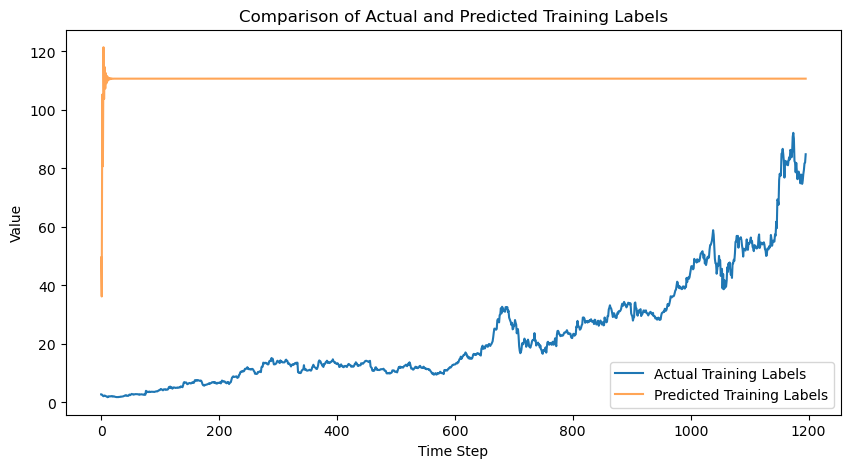

In [ ]:
for data, labels in train_loader:
    train_predictions = generate_predictions(data.view(-1, 21), lstm_model)
    # Convert train_labels to a list or a numpy array if it's a tensor
    train_labels_list = labels.squeeze().tolist()  # Adjust based on your actual format

    # Plot the actual and predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(train_labels_list, label='Actual Training Labels')
    plt.plot(train_predictions, label='Predicted Training Labels', alpha=0.7)
    plt.title('Comparison of Actual and Predicted Training Labels')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()